## Sagnac Frequency - Backscatter Correction - RZ FSR

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv, DatetimeIndex
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d


In [2]:
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.reduce import __reduce


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

# sampling time
config['delta'] = 60

# with GPS reference and new settings
config['tbeg'] = UTCDateTime("2024-08-30 00:00")
config['tend'] = UTCDateTime("2024-09-06 00:00")
config['flim1'], config['flim2'] = 553.568, 553.582

# specify path to data
config['path_to_data'] = data_path+"manuscripts/manuscript_romy_drifts/data/"

# specify path to store figures
config['path_to_figs'] = data_path+"manuscripts/manuscript_romy_drifts/figures/"


### Load Backscatter Data

In [5]:
bs = read_pickle(config['path_to_data']+"bs_fsr_ex2.pkl")

In [6]:
# update time seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - config['tbeg'])

bs = bs[(bs.time1 >= config['tbeg']) & (bs.time2 <= config['tend'])]

### Load PROMY Data

In [9]:
ps = read(config['path_to_data']+"rz_fsr_promy.mseed")
ps

5 Trace(s) in Stream:
BW.PROMY.01.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-05T00:00:00.000000Z | 1.0 Hz, 561601 samples
BW.PROMY.03.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-05T00:00:00.000000Z | 1.0 Hz, 561601 samples
BW.PROMY.05.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-05T00:00:00.000000Z | 1.0 Hz, 561601 samples
BW.PROMY.07.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-05T00:00:00.000000Z | 1.0 Hz, 561601 samples
BW.PROMY.09.LKI | 2024-08-29T12:00:00.000000Z - 2024-09-05T00:00:00.000000Z | 1.0 Hz, 561601 samples

### Load LXX Data

In [10]:
lxx = read_pickle(config['path_to_data']+f"rz_fsr_lxx.pkl")

lxx_t1 = lxx['t1']
lxx_t2 = lxx['t2']

### Load Beam Wander Data

In [13]:
df01 = read_pickle(config['path_to_data']+"ids01_fsr.pkl")

df03 = read_pickle(config['path_to_data']+"ids03_fsr.pkl")

df05 = read_pickle(config['path_to_data']+"ids05_fsr.pkl")

In [14]:
def __process(df0):

    # cut to time period
    df0 = df0[(df0.time_utc >= config['tbeg']) & (df0.time_utc <= config['tend'])]

    df0.loc[:, 'y_um_rel'] = __reduce(df0.y_um_rel, 3)
    df0.loc[:, 'x_um_rel'] = __reduce(df0.x_um_rel, 3)

    df0.reset_index(drop=True, inplace=True)
    return df0

In [15]:
df01 = __process(df01)
df03 = __process(df03)
df05 = __process(df05)

### Load Infrasound FFBI

In [18]:
ffbi = read(config['path_to_data']+"rz_fsr_ffbi.mseed")

In [19]:
ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

### Load FSR Data

In [20]:
fsr = read_pickle(config['path_to_data']+"romy_fsr_ex2.pkl")

In [21]:
# cut data period
fsr = fsr[(fsr.time_utc >= config['tbeg']) & (fsr.time_utc <= config['tend'])]

# add relative time in seconds
fsr['time_sec'] = [_t - config['tbeg'] for _t in fsr.time_utc]

In [22]:
fsr

,datetime,x_hz,y_dbm,time_sec,time_utc,x_mod,y_mod,disp,x_mod_avg,x_mod_std,disp_avg,disp_std,x_mod_rel,x_mod_avg_rel,disp_avg_rel
46613,2024-08-30 00:00:00.346797,1.072995e+08,-80.336891,0.346797,2024-08-30T00:00:00.346797Z,1.072995e+08,-80.336891,33.550959,1.072995e+08,0.452135,33.550959,1.413716e-07,-9.41,-9.045701,0.000003
46614,2024-08-30 00:00:01.350817,1.072995e+08,-80.336891,1.350817,2024-08-30T00:00:01.350817Z,1.072995e+08,-80.336891,33.550959,1.072995e+08,0.451974,33.550959,1.413213e-07,-9.41,-9.045903,0.000003
46615,2024-08-30 00:00:02.357867,1.072995e+08,-82.038445,2.357867,2024-08-30T00:00:02.357867Z,1.072995e+08,-82.038445,33.550958,1.072995e+08,0.451813,33.550959,1.412710e-07,-8.69,-9.046104,0.000003
46616,2024-08-30 00:00:03.360909,1.072995e+08,-82.038445,3.360909,2024-08-30T00:00:03.360909Z,1.072995e+08,-82.038445,33.550958,1.072995e+08,0.451814,33.550959,1.412713e-07,-8.69,-9.046204,0.000003
46617,2024-08-30 00:00:04.365032,1.072995e+08,-83.079697,4.365032,2024-08-30T00:00:04.365032Z,1.072995e+08,-83.079697,33.550959,1.072995e+08,0.451978,33.550959,1.413227e-07,-9.41,-9.046406,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562931,2024-09-04 23:59:55.552471,1.072993e+08,-79.383484,518395.552471,2024-09-04T23:59:55.552471Z,1.072993e+08,-79.383484,33.551007,NaN,NaN,NaN,NaN,-164.98,NaN,NaN
562932,2024-09-04 23:59:56.556407,1.072993e+08,-77.595337,518396.556407,2024-09-04T23:59:56.556407Z,1.072993e+08,-77.595337,33.551007,NaN,NaN,NaN,NaN,-164.98,NaN,NaN
562933,2024-09-04 23:59:57.560326,1.072993e+08,-77.595337,518397.560326,2024-09-04T23:59:57.560326Z,1.072993e+08,-77.595337,33.551007,NaN,NaN,NaN,NaN,-164.98,NaN,NaN
562934,2024-09-04 23:59:58.564246,1.072993e+08,-77.951805,518398.564246,2024-09-04T23:59:58.564246Z,1.072993e+08,-77.951805,33.551007,NaN,NaN,NaN,NaN,-164.98,NaN,NaN


### Linear Fit

27.537206017182715 0.07470302171554577


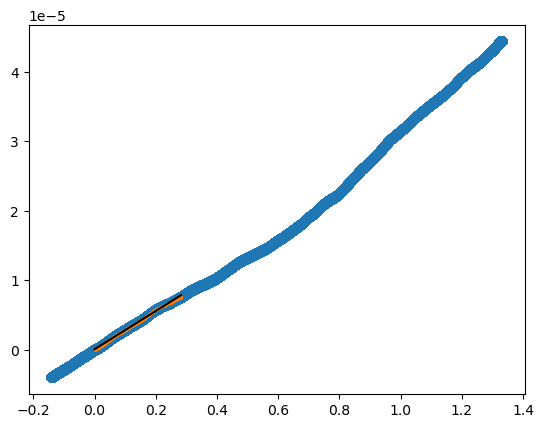

In [23]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from scipy.signal import detrend

N1, N2 = 50_000, 150_000
# N1, N2 = 0, 200_000

# prepare temperature
temp5 = ps.copy().select(location="05")[0]
temp7 = ps.copy().select(location="07")[0]
temp9 = ps.copy().select(location="09")[0]
x_data = temp5.data + temp7.data + temp9.data

# time temp
x_time = temp9.times(reftime=fsr.time_utc.iloc[0])

# interpolate temp data
x_data = np.interp(fsr.time_sec, x_time, x_data)

# prepare displacment data
disp = __interpolate_nan(fsr.disp_avg_rel.values)
y_data = disp

# smooth
y_data = __smooth(y_data, 7200, setpad=True)
x_data = __smooth(x_data, 24*3600, setpad=True)

temp_data_smooth = x_data

# trim
x_data = x_data[N1:N2]
y_data = y_data[N1:N2]

# reduce
x_data = __reduce(x_data, 10)
y_data = __reduce(y_data, 10)

# linear rtemp_data_smoothegression
x, y = x_data, y_data

# linear regression
outT = __compute_orthogonal_distance_regression(x, y)

# reduce temp data
temp_data_smooth -= np.nanmean(temp_data_smooth[N1:N1+10])
disp -= np.nanmean(disp[N1:N1+10])

print(outT[0]*1e6, outT[1]*1e6)

fsr['disp_detrend_temp'] = disp - ( outT[0] * temp_data_smooth + outT[1] )

fsr['disp_as_temp'] = (disp - outT[1]) / outT[0]

plt.scatter(temp_data_smooth, disp)
plt.scatter(x, y, s=.1)
plt.plot(x, outT[1] + x * outT[0], "k")


## Plotting

In [24]:
gc.collect()

60

In [25]:
from functions.find_max_min import __find_max_min

### Interpolate FSR on constant sampling

In [26]:
reftime = fsr.time_utc.iloc[0]

Tsec = int(abs(reftime - fsr.time_utc.iloc[fsr.shape[0]-1]))

time2 = np.arange(0, Tsec, 1)

fsr2 = DataFrame()

fsr2['time_sec'] = time2

fsr2['time_utc'] = [reftime + _t for _t in time2]
fsr2['disp_avg'] = np.interp(time2, fsr.time_sec, fsr.disp_avg)


### Create Common DataFraem

In [27]:
df = DataFrame()

# N1 = 100_000
N1 = 0

dt = 15*60

df['time_utc'] = fsr2.time_utc[N1::dt]

df['time_utc_sec'] = [_t - reftime for _t in df.time_utc]

df['disp'] = fsr2.disp_avg[N1::dt]

df['disp_um'] = df.disp*1e6

df['x_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.x_um_rel)
df['y_01'] = np.interp(df.time_utc_sec, df01.time_utc - UTCDateTime(df.time_utc.iloc[0]), df01.y_um_rel)
df['a_01'] = np.sqrt(df.x_01**2 + df.y_01**2)

df['x_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.x_um_rel)
df['y_03'] = np.interp(df.time_utc_sec, df03.time_utc - UTCDateTime(df.time_utc.iloc[0]), df03.y_um_rel)
df['a_03'] = np.sqrt(df.x_03**2 + df.y_03**2)

df['x_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.x_um_rel)
df['y_05'] = np.interp(df.time_utc_sec, df05.time_utc - UTCDateTime(df.time_utc.iloc[0]), df05.y_um_rel)
df['a_05'] = np.sqrt(df.x_05**2 + df.y_05**2)

df['baro'] = np.interp(df.time_utc_sec, ffbi[1].times(reftime=df.time_utc.iloc[0]), ffbi[1].data)

df['baro_sth'] = __smooth(df.baro, 60)

temp = ps.select(location="05")[0].data + ps.select(location="07")[0].data + ps.select(location="09")[0].data
df['temp'] = np.interp(df.time_utc_sec, ps[0].times(reftime=df.time_utc.iloc[0]), temp)

df['temp_sth'] = __smooth(df.temp, 60)

df = df.dropna()


In [28]:
for k in df.keys():
    if k not in ["time_utc"]:
        df[k+"_rel"] = __reduce(df[k].values, 10)

In [29]:
def __df_to_stream(df0, dt, t1):

    st0 = Stream()

    for k in df.keys():

        _tr = Trace()
        _tr.data = np.array(df[k].values)
        _tr.stats.delta = dt
        _tr.stats.starttime = UTCDateTime(t1)
        _tr.stats.station = k

        st0 += _tr

    return st0

In [30]:
stt = __df_to_stream(df, dt, reftime)

In [31]:
stt = stt.detrend("linear")
stt = stt.detrend("simple")

stt = stt.taper(0.01, type="cosine")

fupper = 1/(1.5*86400)
stt = stt.filter("highpass", freq=fupper, corners=2, zerophase=True)

# stt.plot(equal_scale=False);


In [32]:
def __get_tides(tbeg, tend, component="N", typ="acc", df=3600):

    from pygtide import predict_series
    from numpy import arange, pi
    from obspy import UTCDateTime

    # ROMY
    lat = 48.162941
    lon = 11.275501
    height = 570

    startdate = str(UTCDateTime(tbeg).date)
    duration = (UTCDateTime(tend) - UTCDateTime(tbeg)) / 3600 # in hours
    sampling_rate = df # in seconds

    # creat time vector
    times = arange(0, duration+df/3600, df/3600)

    # prepare arguments
    args = (lat, lon, height, startdate, duration, sampling_rate)

    # specify station azimuth clockwise from north (=0)
    if component == "N":
        statazimut = 0
    elif component == "E":
        statazimut = 90

    if typ == "rad":
        # tides /= 9.81
        tides = predict_series(*args, statgravit=0, statazimut=statazimut, tidalcompo=1) # tilt

        # from mas to rad
        tides = tides * pi / 648000000

    elif typ == "acc":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=0) # horizontal acceleration

        # from nano to acc
        tides *= 1e-9

    elif typ == "str":
        tides = predict_series(*args, statazimut=statazimut, tidalcompo=5) # horizontal strain

        # from nano to str
        tides *= 1e-9

    return times, tides

In [33]:
t1, t2 = UTCDateTime(df.time_utc.iloc[0]).date, (UTCDateTime(df.time_utc.iloc[df.shape[0]-1])+86400).date

deltaT = 900

# predict tidal tilts
# timesN1, tideN1 = __get_tides(t1, t2, component="N", typ="rad", df=deltaT)
# timesE1, tideE1 = __get_tides(t1, t2, component="E", typ="rad", df=deltaT)

# predict horizontal strain
timesN3, tideN3 = __get_tides(t1, t2, component="N", typ="str", df=deltaT)
timesE3, tideE3 = __get_tides(t1, t2, component="E", typ="str", df=deltaT)

_tr = Trace()
_tr.data = tideE3
_tr.stats.delta = deltaT
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

# add to frame
df['tideE'] = np.interp(df.time_utc_sec, _tr.times(reftime=reftime), _tr.data)

_tr = Trace()
_tr.data = tideN3
_tr.stats.delta = deltaT
_tr.stats.starttime = UTCDateTime(t1)

_t1, _t2 = UTCDateTime(df.time_utc.iloc[0]), UTCDateTime(df.time_utc.iloc[df.shape[0]-1])
_tr = _tr.trim(_t1, _t2)

# add to frame
df['tideN'] = np.interp(df.time_utc_sec, _tr.times(reftime=reftime), _tr.data)


# tideNE = np.cos(np.deg2rad(30))*tideN3 + np.sin(np.deg2rad(30))*tideE3

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:348: UserWarning: Please consider updating the leap second database 'b'etddt.dat        '' (last value is from 2017-01-01 00:00:00).
  warn("Please consider updating the leap second database '%s' (last value is from %s)." % (fname, self.etddt_end))
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/pygtide/core.py:352: UserWarning: Dates exceed permissible range for pole/LOD tide correction (interval 1962-01-01 00:00:00 to 2023-06-10 00:00:00). Consider update file 'b'etddt.dat        ''.
  warn("Dates exceed permissible range for pole/LOD tide correction (interval %s to %s). Consider update file '%s'." % (self.etpolut1_start, self.etpolut1_end, fname))


### Plotting

In [34]:
def __makeplot():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from scipy.signal import detrend

    # ___________________________________________

    tscale, tunit = 1/3600, "hour"

    reftime = df.time_utc.iloc[0]

    Ncol, Nrow = 8, 3

    font = 12

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.3, wspace=0.4)

    ax10 = fig.add_subplot(gs1[0, :6])
    ax11 = fig.add_subplot(gs1[0, 6:])
    ax20 = fig.add_subplot(gs1[1, :6])
    ax21 = fig.add_subplot(gs1[1, 6:])
    ax30 = fig.add_subplot(gs1[2, :6])
    ax31 = fig.add_subplot(gs1[2, 6:])

    axes0 = [ax10, ax20, ax30]
    axes1 = [ax11, ax21, ax31]

    # ___________________________________________

    ax10.plot(df.time_utc_sec*tscale, df.disp_um_rel,
              color="purple", label="$\Delta$P")
    ax10.plot(df.time_utc_sec*tscale, df.temp_sth_rel*30,
              color='k', label="$\Delta$T x 30 $\mu$m/°C")

    _fac = -3
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
    #           color="tab:blue", label=f"{_fac}x IDS01-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
    #           color="tab:orange", label=f"{_fac}x IDS03-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
    #           color="tab:red", label=f"{_fac}x IDS05-X")

#     ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_01_rel, s=1, color="tab:blue")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_03_rel, s=1, color="tab:orange")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_05_rel, s=1, color="tab:red")

    _fac = 1
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
              color="tab:blue", label= "IDS01-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
              color="tab:orange", label="IDS03-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
              color="tab:red", label="IDS05-A")

    ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_01_rel, s=1, color="tab:blue")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_03_rel, s=1, color="tab:orange")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_05_rel, s=1, color="tab:red")

    # ___________________________________________

    ax20.plot(df.time_utc_sec*tscale, detrend(df.baro_rel, type="linear"),
              color='k', label="FFBI x 1 $\mu$m/hPa (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_01_rel, type="linear"),
              color="tab:blue", label="-1x IDS01-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_03_rel, type="linear"),
              color="tab:orange", label="-1x IDS03-Y (detrend)")
    ax20.plot(df.time_utc_sec*tscale, -detrend(df.y_05_rel, type="linear"),
              color="tab:red", label="-1x IDS05-Y (detrend)")

    # ax20.plot(df.time_utc_sec*tscale, stt.select(station="baro")[0].data,
    #           color='k', label=f"FFBI x 1 $\mu$m/hPa (highpass < {int(1/fupper/3600)}h)")

    _sfac = 4
    ax20.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*_sfac,
              color="purple", label=f"{_sfac}x $\Delta$P (highpass < {int(1/fupper/3600)}h)")

    ax21.scatter(detrend(df.baro_rel, type="linear"), detrend(df.disp_um_rel, type="linear"),
                 s=1, color="purple")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_01_rel, type="linear"),
                 s=1, color="tab:blue")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_03_rel, type="linear"),
                 s=1, color="tab:orange")
    ax21.scatter(detrend(df.baro_rel, type="linear"), -detrend(df.y_05_rel, type="linear"),
                 s=1, color="tab:red")

    # ___________________________________________

    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_01, type="linear")/33.5*1e3,
              color="tab:blue", label="IDS01-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_03, type="linear")/33.5*1e3,
              color="tab:orange", label="IDS03-X / P", alpha=0.7)
    ax30.plot(df.time_utc_sec*tscale, detrend(df.x_05, type="linear")/33.5*1e3,
              color="tab:red", label="IDS05-X / P", alpha=0.7)

    x_sum = detrend(df.x_03, type="linear")+detrend(df.x_05, type="linear")
    ax30.plot(df.time_utc_sec*tscale, x_sum/33.5*1e3,
              color="k", ls="--", label="(IDS03-X + IDS05-X) / P")

    ax30.plot(df.time_utc_sec*tscale, df.tideE*1e9, color='k', label="Tidal Strain-E")

    # ax31.scatter(df.tideE*1e9, detrend(df.x_01, type="linear")/33.5*1e3,
    #              s=1, color="tab:blue")
    # ax31.scatter(df.tideE*1e9, detrend(df.x_03, type="linear")/33.5*1e3,
    #              s=1, color="tab:orange")
    # ax31.scatter( f.tideE*1e9, detrend(df.x_05, type="linear")/33.5*1e3,
    #              s=1, color="tab:red")

    ax31.scatter(df.tideE*1e9, x_sum/33.5*1e3,
                 s=1, color="k")

    ax10.set_ylim(-5, 50)
    ax11.set_ylim(-5, 50)

    ax30.set_ylim(-40, 40)
    ax31.set_ylim(-40, 40)
    ax31.set_xlim(-40, 40)

    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)','(e)','(f)'], axes0+axes1)):
        ax.text(0.008, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    for ax in axes0:
        ax.set_xlim(0, (config['tend']-config['tbeg']-86400)*tscale)
        ax.set_xlabel(f"Time ({tunit})", fontsize=font)
    for ax in axes0+axes1:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    ax10.legend(loc=9, ncol=3)
    ax20.legend(loc=8, ncol=3)
    ax30.legend(loc=8, ncol=5)

    ax10.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax20.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax30.set_ylabel(f"rel. Displacement (nm)", fontsize=font)

    ax11.set_xlabel(f"rel. Temperature (°C)", fontsize=font)
    ax21.set_xlabel(f"rel. Pressure (hPa)", fontsize=font)
    ax31.set_xlabel(f"Strain (nm)", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}_gps_analysis.png",
#             format="png", dpi=150, bbox_inches='tight')


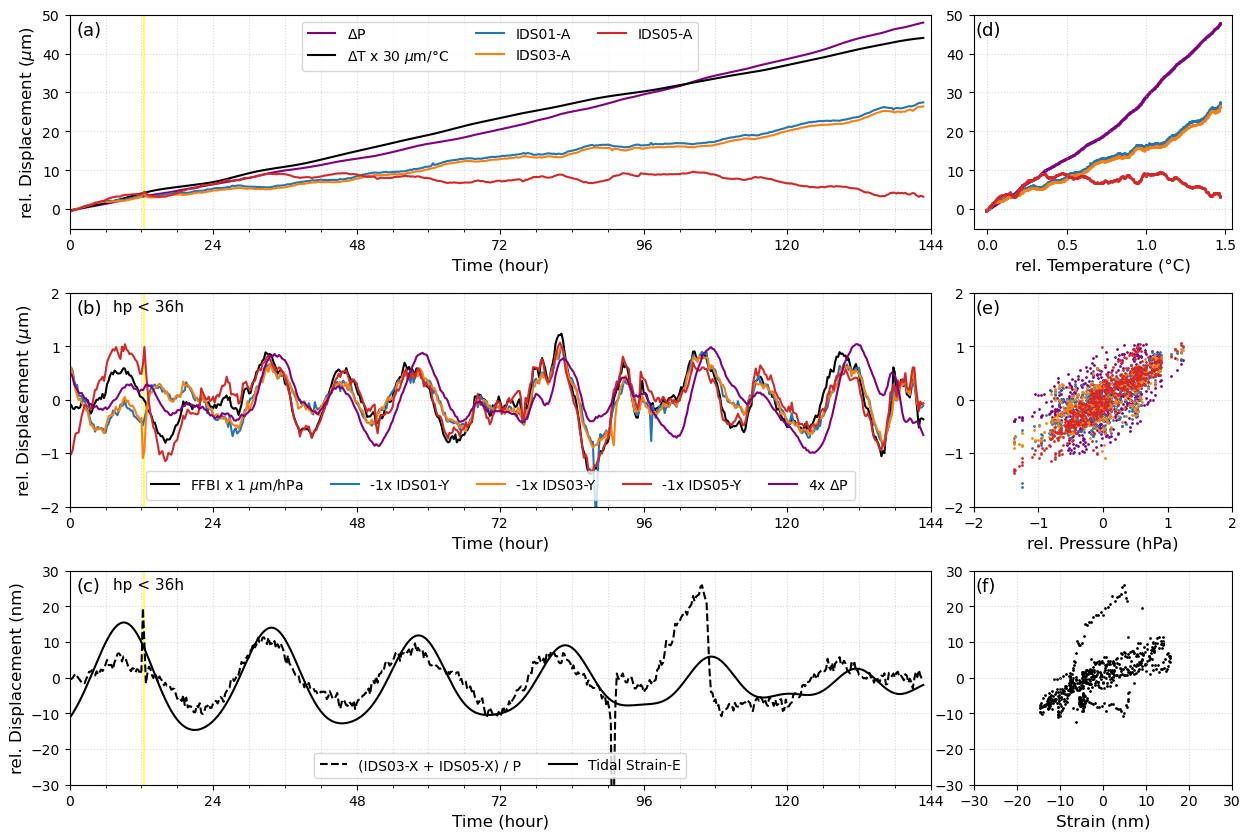

In [38]:
def __makeplot2():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from scipy.signal import detrend
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    # ___________________________________________

    tscale, tunit = 1/3600, "hour"

    reftime = df.time_utc.iloc[0]

    Ncol, Nrow = 8, 3

    font = 12

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.3, wspace=0.4)

    ax10 = fig.add_subplot(gs1[0, :6])
    ax11 = fig.add_subplot(gs1[0, 6:])
    ax20 = fig.add_subplot(gs1[1, :6])
    ax21 = fig.add_subplot(gs1[1, 6:])
    ax30 = fig.add_subplot(gs1[2, :6])
    ax31 = fig.add_subplot(gs1[2, 6:])

    axes0 = [ax10, ax20, ax30]
    axes1 = [ax11, ax21, ax31]

    # ___________________________________________

    ax10.plot(df.time_utc_sec*tscale, df.disp_um_rel,
              color="purple", label="$\Delta$P")
    ax10.plot(df.time_utc_sec*tscale, df.temp_sth_rel*30,
              color='k', label="$\Delta$T x 30 $\mu$m/°C")

    _fac = -3
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
    #           color="tab:blue", label=f"{_fac}x IDS01-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
    #           color="tab:orange", label=f"{_fac}x IDS03-X")
    # ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
    #           color="tab:red", label=f"{_fac}x IDS05-X")

#     ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_01_rel, s=1, color="tab:blue")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_03_rel, s=1, color="tab:orange")
#     ax11.scatter(df.temp_sth_rel, _fac*df.x_05_rel, s=1, color="tab:red")

    _fac = 1
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_01_rel,
              color="tab:blue", label= "IDS01-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_03_rel,
              color="tab:orange", label="IDS03-A")
    ax10.plot(df.time_utc_sec*tscale, _fac*df.a_05_rel,
              color="tab:red", label="IDS05-A")

    ax11.scatter(df.temp_sth_rel, df.disp_um_rel, s=1, color="purple")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_01_rel, s=1, color="tab:blue")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_03_rel, s=1, color="tab:orange")
    ax11.scatter(df.temp_sth_rel, _fac*df.a_05_rel, s=1, color="tab:red")

    # ___________________________________________

    ax20.plot(df.time_utc_sec*tscale, stt.select(station="baro")[0].data,
              color='k', label="FFBI x 1 $\mu$m/hPa")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_01")[0].data,
              color="tab:blue", label="-1x IDS01-Y")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_03")[0].data,
              color="tab:orange", label="-1x IDS03-Y")
    ax20.plot(df.time_utc_sec*tscale, -stt.select(station="y_05")[0].data,
              color="tab:red", label="-1x IDS05-Y")
    _sfac = 4
    ax20.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*_sfac,
              color="purple", label=f"{_sfac}x $\Delta$P",
             )

    ax21.scatter(stt.select(station="baro")[0].data, stt.select(station="disp")[0].data*1e6*_sfac,
                 s=1, color="purple")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_01")[0].data,
                 s=1, color="tab:blue")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_03")[0].data,
                 s=1, color="tab:orange")
    ax21.scatter(stt.select(station="baro")[0].data, -stt.select(station="y_05")[0].data,
                 s=1, color="tab:red")

    # ___________________________________________

    # ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_01")[0].data/33.5*1e3,
    #           color="tab:blue", label="IDS01-X / P", alpha=0.7)
    # ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_03")[0].data/33.5*1e3,
    #           color="tab:orange", label="IDS03-X / P", alpha=0.7)
    # ax30.plot(df.time_utc_sec*tscale, stt.select(station="x_05")[0].data/33.5*1e3,
    #           color="tab:red", label="IDS05-X / P", alpha=0.7)

    x_sum = stt.select(station="x_03")[0].data+stt.select(station="x_05")[0].data
    ax30.plot(df.time_utc_sec*tscale, x_sum/33.5*1e3,
              color="k", ls="--", label="(IDS03-X + IDS05-X) / P")

    ax30.plot(df.time_utc_sec*tscale, df.tideE*1e9, color='k', label="Tidal Strain-E")

    # ax30.plot(df.time_utc_sec*tscale, stt.select(station="disp")[0].data*1e6*33.5,
    #           color="purple", label=f"$\Delta$P",
    #          )

    # ax31.scatter(df.tideE*1e9, detrend(df.x_01, type="linear")/33.5*1e3,
    #              s=1, color="tab:blue")
    # ax31.scatter(df.tideE*1e9, detrend(df.x_03, type="linear")/33.5*1e3,
    #              s=1, color="tab:orange")
    # ax31.scatter( f.tideE*1e9, detrend(df.x_05, type="linear")/33.5*1e3,
    #              s=1, color="tab:red")

    ax31.scatter(df.tideE*1e9, x_sum/33.5*1e3,
                 s=1, color="k")

    ax10.set_ylim(-5, 50)
    ax11.set_ylim(-5, 50)

    ax20.set_ylim(-2, 2)
    ax21.set_ylim(-2, 2)
    ax21.set_xlim(-2, 2)

    ax30.set_ylim(-30, 30)
    ax31.set_ylim(-30, 30)
    ax31.set_xlim(-30, 30)

    for ax in axes0:
        ax.xaxis.set_major_locator(MultipleLocator(24))
        ax.xaxis.set_minor_locator(MultipleLocator(6))

    for _k, (ll, ax) in enumerate(zip(['(a)','(b)','(c)','(d)','(e)','(f)'], axes0+axes1)):
        ax.text(0.008, 0.97, ll, ha="left", va="top", transform=ax.transAxes, fontsize=font+1)

    for ax in axes0:
        ax.set_xlim(0, (config['tend']-config['tbeg']-86400)*tscale)
        ax.set_xlabel(f"Time ({tunit})", fontsize=font)

        _, _ , _ymin, _ymax = ax.axis()

        # add maintenance
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(reftime)
            lx2_sec = lx2-UTCDateTime(reftime)
            ax.fill_betweenx([_ymin*5, _ymax*5], lx1_sec*tscale, lx2_sec*tscale, color="yellow", alpha=0.5)

    for ax in axes0+axes1:
        ax.grid(ls=":", alpha=0.5, zorder=0, which="both")

    ax20.text(0.05, 0.97, f"hp < {int(1/fupper/3600)}h", ha="left", va="top", transform=ax20.transAxes, fontsize=font-1)
    ax30.text(0.05, 0.97, f"hp < {int(1/fupper/3600)}h", ha="left", va="top", transform=ax30.transAxes, fontsize=font-1)

    ax10.legend(loc=9, ncol=3)
    ax20.legend(loc=8, ncol=5)
    ax30.legend(loc=8, ncol=5)

    ax10.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax20.set_ylabel(f"rel. Displacement ($\mu$m)", fontsize=font)
    ax30.set_ylabel(f"rel. Displacement (nm)", fontsize=font)

    ax11.set_xlabel(f"rel. Temperature (°C)", fontsize=font)
    ax21.set_xlabel(f"rel. Pressure (hPa)", fontsize=font)
    ax31.set_xlabel(f"Strain (nm)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot2()

fig.savefig(config['path_to_figs']+f"FSR_RZ_{config['tbeg']}_{config['tend']}_gps_analysis_hp.png",
            format="png", dpi=150, bbox_inches='tight')
